In [1]:
import topostats as topo
from topostats import filters
from topostats import io
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import logging
LOGGER = logging.getLogger()
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import feature
import skimage.filters
import skimage.measure
import skimage.morphology
import skimage.color
import cv2
import scipy.ndimage as ndimage

In [12]:
def plane_tilt_removal(image: np.ndarray):
    read_matrix = image.copy()
    # Line of best fit
    # Calculate medians
    medians_x = [np.nanmedian(read_matrix[:, i]) for i in range(read_matrix.shape[1])]
    medians_y = [np.nanmedian(read_matrix[j, :]) for j in range(read_matrix.shape[0])]

    # Fit linear x
    px = np.polyfit(range(0, len(medians_x)), medians_x, 1)
    LOGGER.info(f"x-polyfit 1st order: {px}")
    py = np.polyfit(range(0, len(medians_y)), medians_y, 1)
    LOGGER.info(f"y-polyfit 1st order: {py}")

    if px[0] != 0:
        if not np.isnan(px[0]):
            LOGGER.info(f"Removing x plane tilt")
            for row in range(0, image.shape[0]):
                for col in range(0, image.shape[1]):
                    image[row, col] -= px[0] * (col)
        else:
            LOGGER.info(f"x gradient is nan, skipping plane tilt x removal")
    else:
        LOGGER.info("x gradient is zero, skipping plane tilt x removal")

    if py[0] != 0:
        if not np.isnan(py[0]):
            LOGGER.info(f"removing y plane tilt")
            for row in range(0, image.shape[0]):
                for col in range(0, image.shape[1]):
                    image[row, col] -= py[0] * (row)
        else:
            LOGGER.info("y gradient is nan, skipping plane tilt y removal")
    else:
        LOGGER.info("y gradient is zero, skipping plane tilt y removal")

    return image

def scale_heightmap(heightmap):
    heightmap = heightmap.astype(np.float32)
    min_value = heightmap.min()
    max_value = heightmap.max()
    heightmap = (heightmap - min_value) / (max_value - min_value)
    heightmap = heightmap * 255
    heightmap = heightmap.astype(np.uint8)
    return heightmap

def plot(img, title=''):
    plt.imshow(img)
    plt.title(title)
    plt.show()

[Sun, 12 Feb 2023 12:48:04] [INFO    ] [topostats] Extracting image from alex-data/20230207_Me4_NPs_perov_10um.0_00007.spm
[Sun, 12 Feb 2023 12:48:04] [INFO    ] [topostats] Loading image from : alex-data/20230207_Me4_NPs_perov_10um.0_00007.spm
[Sun, 12 Feb 2023 12:48:04] [INFO    ] [topostats] [20230207_Me4_NPs_perov_10um.0_00007] : Loaded image from : alex-data/20230207_Me4_NPs_perov_10um.0_00007.spm
[Sun, 12 Feb 2023 12:48:04] [INFO    ] [topostats] [20230207_Me4_NPs_perov_10um.0_00007] : Extracted channel Height Sensor
[Sun, 12 Feb 2023 12:48:04] [INFO    ] [topostats] [20230207_Me4_NPs_perov_10um.0_00007] : Pixel to nm scaling : 19.53125
[Sun, 12 Feb 2023 12:48:04] [INFO    ] [topostats] Loading image from : alex-data/20230207_Me4_NPs_perov_10um.0_00007.spm
[Sun, 12 Feb 2023 12:48:04] [INFO    ] [topostats] [20230207_Me4_NPs_perov_10um.0_00007] : Loaded image from : alex-data/20230207_Me4_NPs_perov_10um.0_00007.spm
[Sun, 12 Feb 2023 12:48:04] [INFO    ] [topostats] [20230207_Me4_N

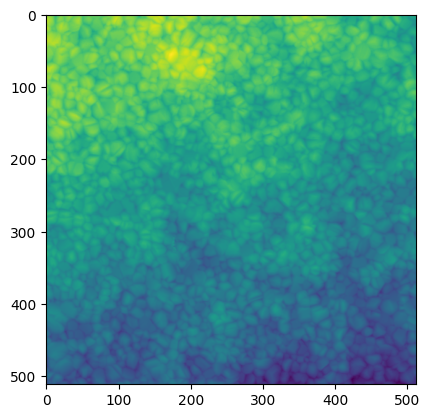

In [4]:
# file = Path('./alex-data/20230207_Me4_NPs_perov_5um.0_00006.spm')
file = Path('./alex-data/20230207_Me4_NPs_perov_10um.0_00007.spm')
loadscan = io.LoadScans(img_paths = [file], channel='Height Sensor')
loadscan.get_data()
data, pixel_to_nm = loadscan.load_spm()
plt.imshow(data)

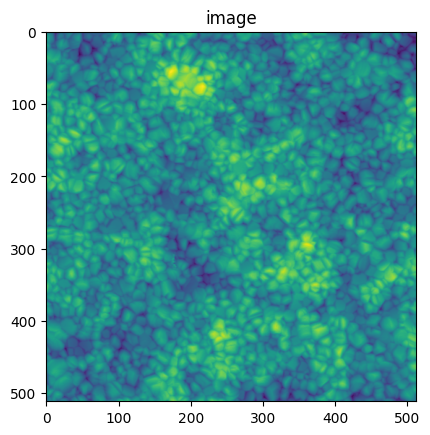

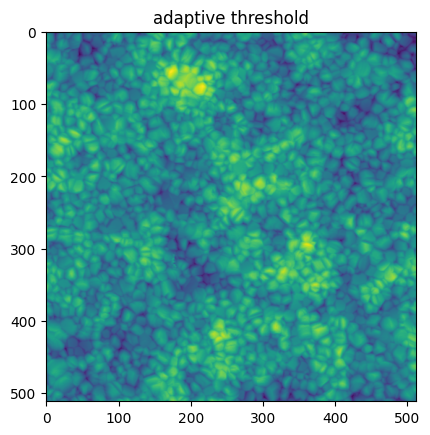

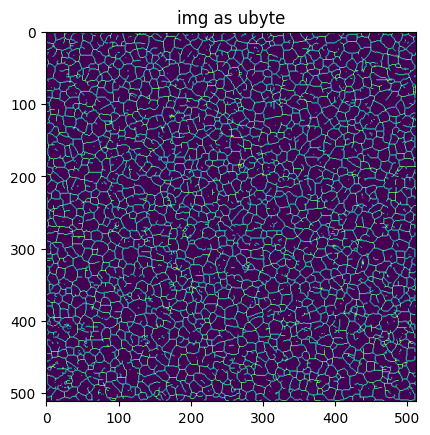

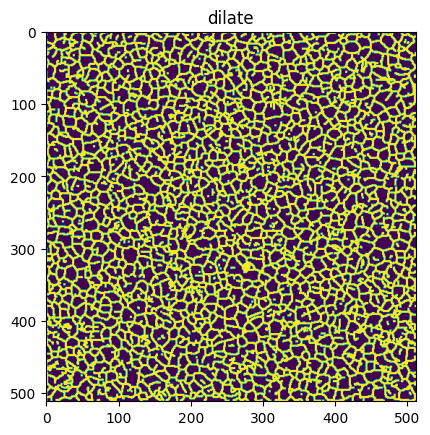

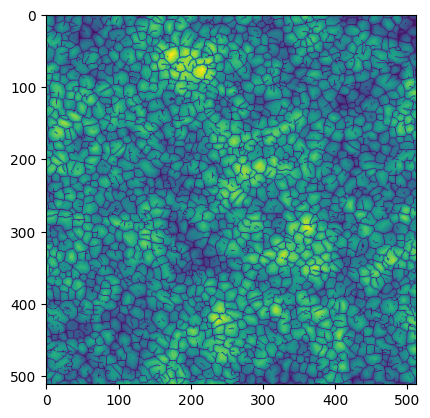

In [41]:
img = data.copy()
img = plane_tilt_removal(img)
img = scale_heightmap(img)
plot(img, 'image')
# img2 = cv2.medianBlur(img, 5)
# plot(img2, 'blur')
# img3 = cv2.bilateralFilter(img2, 9, 75, 75)
# plot(img3, 'bilateral filter')
img4 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 0)
plot(img, 'adaptive threshold')
img5 = skimage.img_as_ubyte(skimage.morphology.skeletonize(skimage.img_as_bool(img4)))
plot(img5, 'img as ubyte')
img6 = cv2.dilate(img5, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=1)
plot(img6, 'dilate')

edges = (img5 != 0)
masked_img = np.ma.masked_array(img, img5!=0, fill_value=5).filled()
plt.imshow(masked_img)
plt.show()

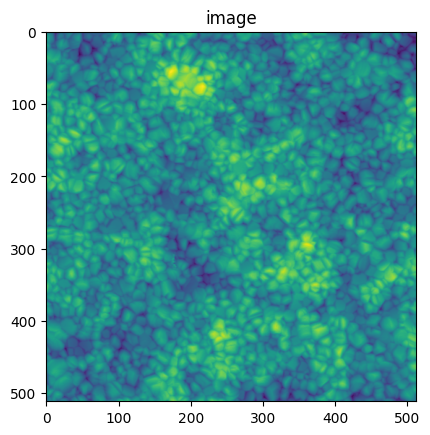

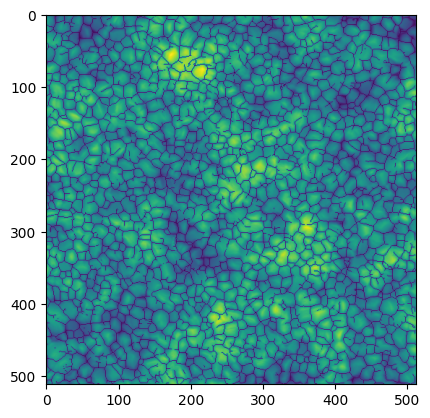

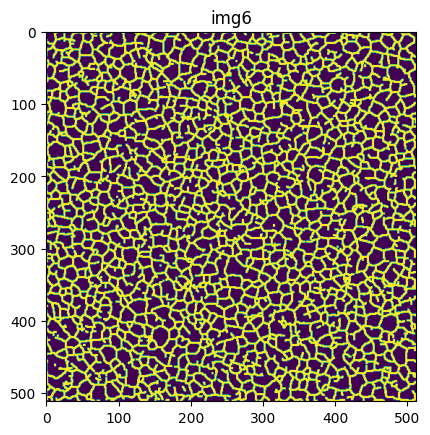

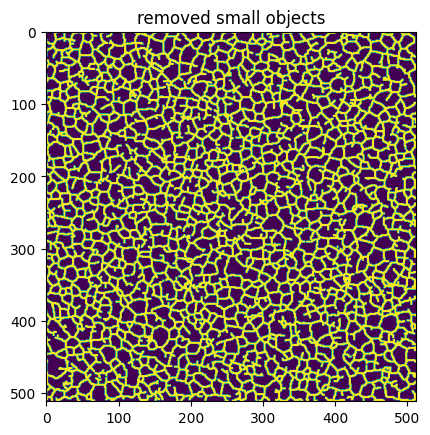

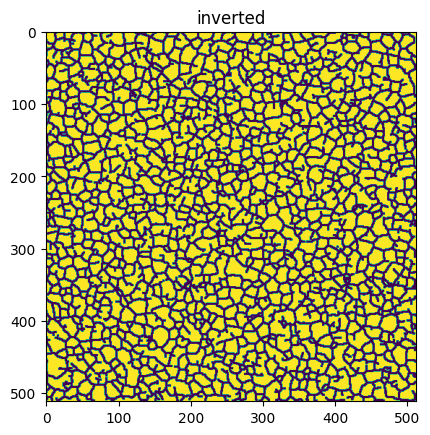

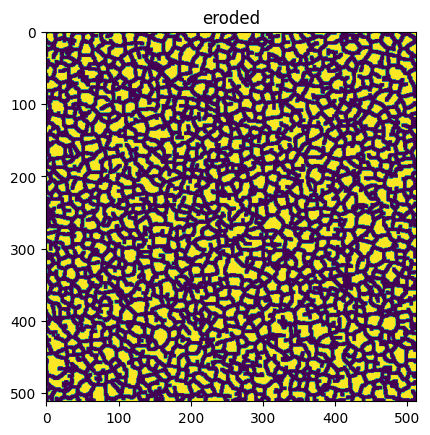

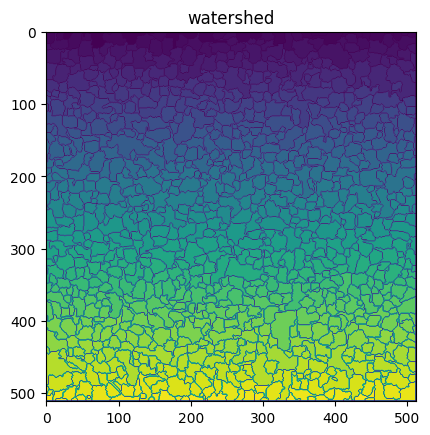

In [171]:
img = data.copy()
img = plane_tilt_removal(img)
img = scale_heightmap(img)
plot(img, 'image')
img4 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 27, 0)
img5 = skimage.img_as_ubyte(skimage.morphology.skeletonize(skimage.img_as_bool(img4)))
img6 = cv2.dilate(img5, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=1)
edges = (img5 != 0)
masked_img = np.ma.masked_array(img, edges, fill_value=5).filled()
plt.imshow(masked_img)
plt.show()

plot(img6, 'img6')

removed_small_objects = skimage.morphology.remove_small_objects(img6.astype(bool), min_size=100)
plot(removed_small_objects, 'removed small objects')

inverted = np.invert(removed_small_objects)
# inverted = cv2.erode(inverted)
plot(inverted, 'inverted')

# eroded = skimage.morphology.binary_erosion(inverted)
eroded = cv2.erode(inverted.astype(np.uint8), kernel=np.ones((3,3),np.uint8), iterations=1)
plot(eroded, 'eroded')

ret, markers = cv2.connectedComponents(np.uint8(eroded))

watershed = cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers.astype(np.int32))
plot(watershed, 'watershed')

# sure_bg = np.invert(img5)
# plot(sure_bg, 'sure_background')

# kernel = np.ones((3,3),np.uint8)
# sure_fg = cv2.erode(sure_bg, kernel, iterations=1)
# sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_CLOSE, kernel)

# dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 5)
# plot(dist_transform, 'distance transform')

# ret, sure_fg = cv2.threshold(dist_transform, 0.1*dist_transform.max(), 255, 0)
# plot(sure_fg, 'sure foreground')

# Find unknown region
# sure_fg = np.uint8(sure_fg)
# plot(sure_fg, 'sure foreground')
# unknown = cv2.subtract(sure_bg, sure_fg)
# plot(unknown, 'unknown')

# ret, markers = cv2.connectedComponents(sure_fg)
# plot(markers, 'markers')

# markers = markers + 1
# # markers[unknown==255] = 0
# markers = markers.astype(np.int32)

# Convert image to 3-channel colour
# img_3_channel = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
# plot(img_3_channel, 'img 3 channel')

# watershed_markers = cv2.watershed(img_3_channel, markers)
# plot(watershed_markers, 'watershed')

# fig, ax = plt.subplots(1, 2, figsize=(10,20))
# ax[0].imshow(img)
# ax[1].imshow(watershed_markers)
# plt.show()

# kernel = np.ones((3,3),np.uint8)
# opening = cv2.morphologyEx(inverted,cv2.MORPH_OPEN,kernel, iterations = 1)
# plot(opening, 'opening')

# sure_bg = cv2.dilate(opening, kernel, iterations=3)
# plot(sure_bg, 'sure_bg')

# inverted_edges = np.invert(edges)
# labelled = skimage.measure.label(inverted_edges, background=0, connectivity=1)

# num_labels, markers = cv2.connectedComponents(sure_bg, connectivity=4)
# plot(markers, 'labelled')

# labels_im = labels_im + 1

# watershed_markers = watershed = cv2.watershed(img, markers)
# plot(watershed_markers, 'watershed')


# plot(labelled[0:10, 0:10], 'labelled')
# print(labelled[0:10, 0:10])

# plot(labelled[440:450, 440:450], 'labelled')
# print(labelled[440:450, 440:450])

# print(inverted_edges)
# boolean_areas = (inverted_edges == 255).astype(int)
# print(boolean_areas)
# labels = cv2.connectedComponents(boolean_areas)
# print(labels)
# plot(labels[1])


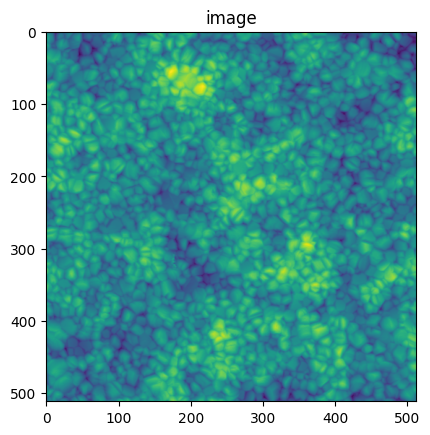

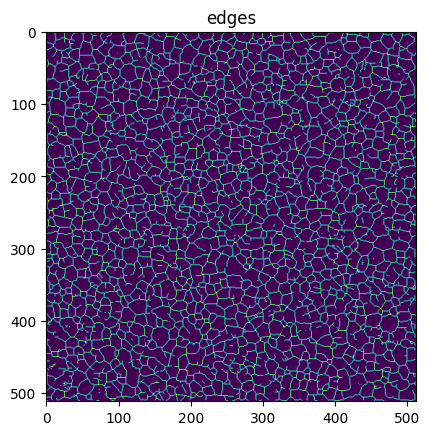

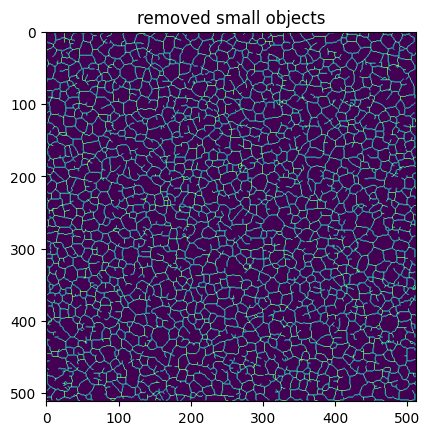

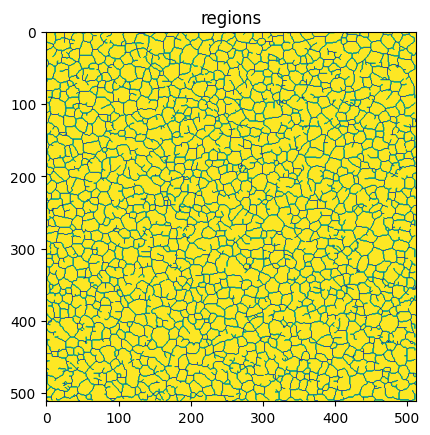

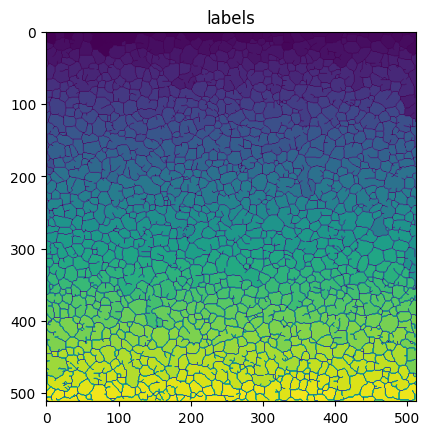

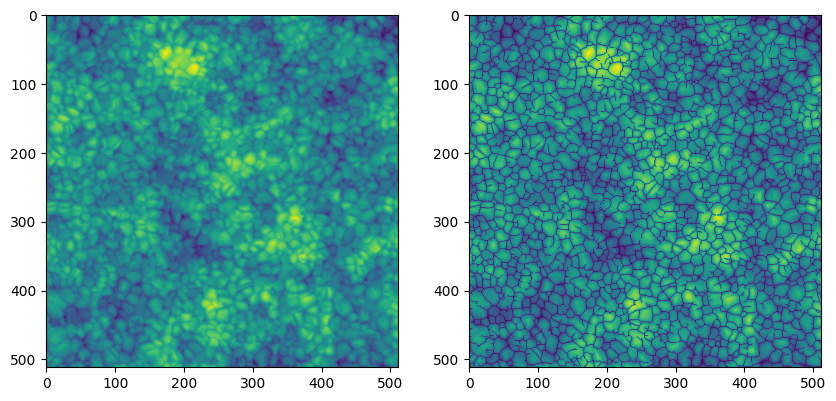

In [197]:
img = data.copy()
img = plane_tilt_removal(img)
img = scale_heightmap(img)
plot(img, 'image')
img4 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 0)
img5 = skimage.img_as_ubyte(skimage.morphology.skeletonize(skimage.img_as_bool(img4)))
img6 = cv2.dilate(img5, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=1)
edges = (img5 != 0)
plot(edges, 'edges')
edges = skimage.morphology.remove_small_objects(edges.astype(bool),connectivity=8 ,min_size=100)
plot(edges, 'removed small objects')
masked_img = np.ma.masked_array(img, edges, fill_value=5).filled()

regions = np.invert(edges)
plot(regions, 'regions')

labels = skimage.measure.label(regions, connectivity=1)
plot(labels, 'labels')

fig, ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(img)
ax[1].imshow(masked_img)
plt.show()

In [54]:
help(cv2.connectedComponents)

Help on built-in function connectedComponents:

connectedComponents(...)
    connectedComponents(image[, labels[, connectivity[, ltype]]]) -> retval, labels
    .   @overload
    .   
    .   @param image the 8-bit single-channel image to be labeled
    .   @param labels destination labeled image
    .   @param connectivity 8 or 4 for 8-way or 4-way connectivity respectively
    .   @param ltype output image label type. Currently CV_32S and CV_16U are supported.



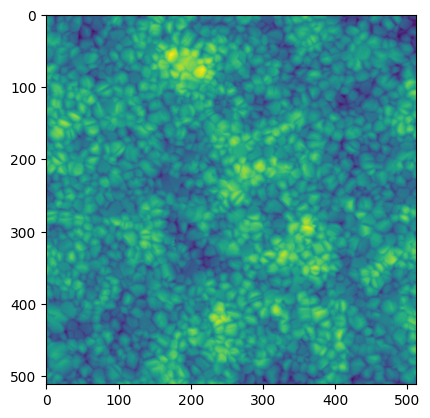

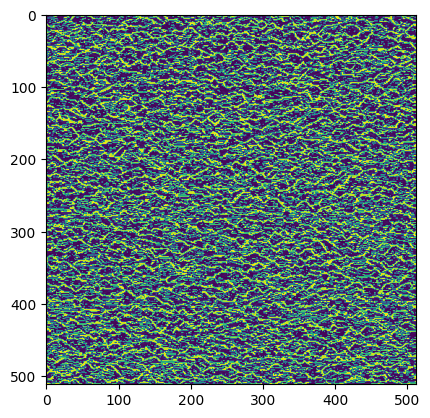

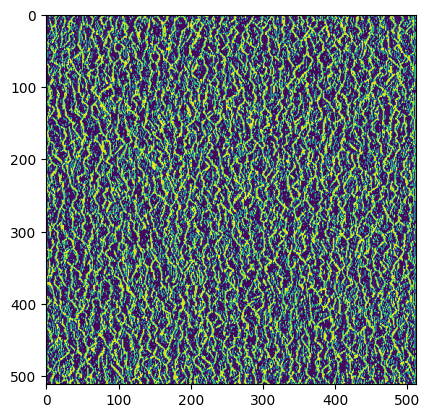

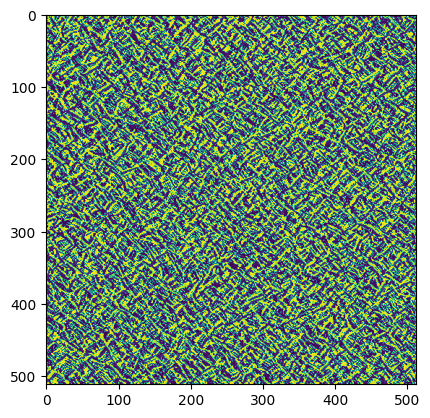

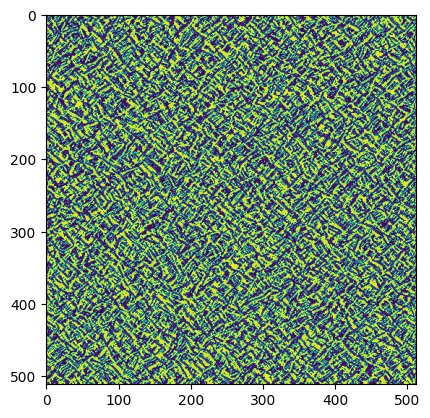

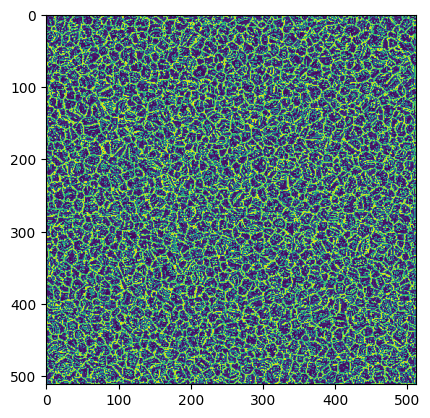

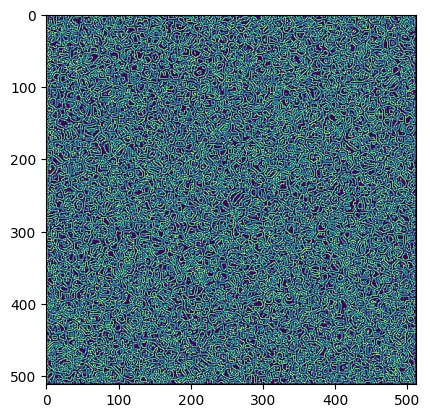

In [155]:
img = data.copy()
img = plane_tilt_removal(img)
img = scale_heightmap(img)
plot(img)

# max = img.max()
# for height in range(20, 40):
#     filter = img < (max - height*2)
#     img_slice = np.ma.masked_array(img, filter, fill_value=0).filled()
#     plot(img_slice)

# sigmas = np.linspace(0.1, 1, 10)
# for sigma in sigmas:
#     canny_img = feature.canny(img, sigma=sigma)
#     plot(canny_img)


kernel1 = [
    [-1, -1, -1],
    [2, 2, 2],
    [-1, -1, -1],
]

kernel2 = [
    [-1, 2, -1],
    [-1, 2, -1],
    [-1, 2, -1],
]

kernel3 = [
    [2, -1, -1],
    [-1, 2, -1],
    [-1, -1, 2],
]

kernel4 = [
    [-1, -1, 2],
    [-1, 2, -1],
    [2, -1, -1],
]

conv1 = ndimage.convolve(img, kernel1)
plot(conv1)

conv2 = ndimage.convolve(img, kernel2)
plot(conv2)

conv3 = ndimage.convolve(img, kernel3)
plot(conv3)

conv4 = ndimage.convolve(img, kernel4)
plot(conv4)


convtotal = conv1 + conv2 + conv3 + conv4
plot(convtotal)

cannyconv = feature.canny(convtotal)
plot(cannyconv)

In [ ]:



plane_removed = plane_tilt_removal(data)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
morph = cv2.morphologyEx(plane_removed, cv2.MORPH_CLOSE, kernel)
plt.imshow(morph)
plt.show()

scaled = scale_heightmap(morph)
plt.imshow(scaled)
plt.show()

thresh = cv2.threshold(scaled, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

distance_map = ndimage.distance_transform_edt(thresh)
plt.imshow(distance_map)
plt.show()
local_max = peak_local_max(distance_map, indices=False, footprint=np.ones((51, 51)), labels=thresh)
plt.imshow(local_max)
plt.show()

markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
plt.imshow(markers)
plt.show()

labels = watershed(-distance_map, markers, mask=thresh)
plt.imshow(labels)
plt.show()

In [ ]:
plane_removed = plane_tilt_removal(data)
plt.imshow(plane_removed)
plt.show()

# watershedded = watershed(plane_removed, markers=1000)
# plt.imshow(watershedded)
# plt.show()

canny = feature.canny(plane_removed, sigma=1.0)
plt.imshow(canny)
plt.show()

canny_inverse = (canny==0).astype(bool)
plt.imshow(canny_inverse)
plt.show()

print(canny_inverse[0:10, 0:10])

regions = skimage.morphology.label(canny_inverse, background=0)
plt.imshow(regions)
print(regions)
plt.show()

# watershedded = watershed(canny)
# plt.imshow(watershedded)
# plt.show()